In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.77M/4.77M [00:00<00:00, 47.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prajitdatta/movielens-100k-dataset/versions/1


In [2]:
import pandas as pd
import os

data_path = "/root/.cache/kagglehub/datasets/prajitdatta/movielens-100k-dataset/versions/1/ml-100k"

movies = pd.read_csv(
    os.path.join(data_path, "u.item"),
    sep="|",
    encoding="latin-1",
    names=["movieId", "title", "release_date", "video_release_date", "IMDb_URL",
           "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
           "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
           "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
)

# Gereksiz sütunları kaldır
movies_clean = movies.drop(columns=["video_release_date", "IMDb_URL"])

# release_date eksik olan satırı düşür
movies_clean = movies_clean.dropna(subset=["release_date"])

# Türleri tek bir string sütunda birleştir
genre_columns = movies_clean.columns[5:]
def combine_genres(row):
    return "|".join([genre for genre in genre_columns if row[genre] == 1])

movies_clean["genres_combined"] = movies_clean.apply(combine_genres, axis=1)
movies_clean = movies_clean[["movieId", "title", "genres_combined"]]

In [3]:
ratings = pd.read_csv(
    os.path.join(data_path, "u.data"),
    sep="\t",
    names=["userId", "movieId", "rating", "timestamp"]
)

# Temizlik
ratings_clean = ratings.drop(columns=["timestamp"])
ratings_clean = ratings_clean.dropna(subset=["userId","movieId","rating"])
ratings_clean["rating"] = ratings_clean["rating"].astype(float)

In [4]:
print("\nEksik veri kontrolü:")
print(ratings.isnull().sum())
print(movies.isnull().sum())


Eksik veri kontrolü:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId                  0
title                    0
release_date             1
video_release_date    1682
IMDb_URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children's               0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
dtype: int64


In [5]:
print("🎬 Film sayısı:", movies['movieId'].nunique())
print("👤 Kullanıcı sayısı:", ratings['userId'].nunique())
print("⭐ Toplam puanlama sayısı:", ratings.shape[0])

print("\nKullanıcı başına ortalama puan:", ratings.groupby("userId")["movieId"].count().mean())
print("Film başına ortalama puan:", ratings.groupby("movieId")["userId"].count().mean())

🎬 Film sayısı: 1682
👤 Kullanıcı sayısı: 943
⭐ Toplam puanlama sayısı: 100000

Kullanıcı başına ortalama puan: 106.04453870625663
Film başına ortalama puan: 59.45303210463734


In [6]:
# En çok oylanan 10 film
most_rated = ratings.groupby("movieId")["rating"].count().sort_values(ascending=False).head(10)
print("\nEn çok oylanan filmler:")
print(most_rated)

# Ortalama puanı yüksek olan filmler (min 100 oy şartıyla)
avg_ratings = ratings.groupby("movieId")["rating"].mean()
count_ratings = ratings.groupby("movieId")["rating"].count()
popular_high_rated = avg_ratings[count_ratings > 100].sort_values(ascending=False).head(10)
print("\nEn yüksek ortalama puanlı filmler (100+ oy almış):")
print(popular_high_rated)

# Tür dağılımı
genres = movies.iloc[:,5:].sum().sort_values(ascending=False)
print("\nEn popüler türler:")
print(genres.head(10))


En çok oylanan filmler:
movieId
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
Name: rating, dtype: int64

En yüksek ortalama puanlı filmler (100+ oy almış):
movieId
408    4.491071
318    4.466443
169    4.466102
483    4.456790
64     4.445230
603    4.387560
12     4.385768
50     4.358491
178    4.344000
134    4.292929
Name: rating, dtype: float64

En popüler türler:
Drama         725
Comedy        505
Action        251
Thriller      251
Romance       247
Adventure     135
Children's    122
Crime         109
Sci-Fi        101
Horror         92
dtype: int64


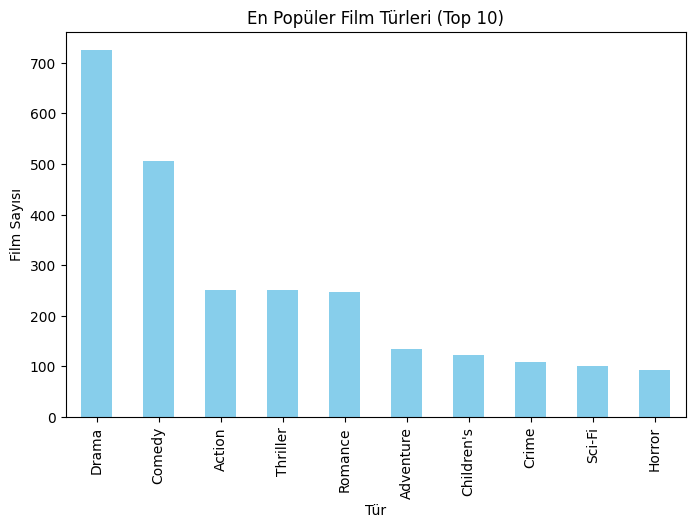

In [7]:
import matplotlib.pyplot as plt

genres.head(10).plot(kind="bar", figsize=(8,5), color="skyblue")
plt.title("En Popüler Film Türleri (Top 10)")
plt.xlabel("Tür")
plt.ylabel("Film Sayısı")
plt.show()

In [8]:
# Kullanılmayacak sütunları kaldır
movies_clean = movies.drop(columns=["video_release_date", "IMDb_URL"])

# release_date eksik olan tek satırı düşürelim
movies_clean = movies_clean.dropna(subset=["release_date"])

# Sadece gerekli sütunları seç
genre_columns = movies_clean.columns[5:]  # tür sütunları
movies_clean = movies_clean[["movieId", "title"] + list(genre_columns)]

In [9]:
# Tür sütunları
genre_columns = movies_clean.columns[5:]  # Action, Comedy, Drama ...

# genres_combined sütunu oluştur
def combine_genres(row):
    return "|".join([genre for genre in genre_columns if row[genre] == 1])

movies_clean["genres_combined"] = movies_clean.apply(combine_genres, axis=1)

# Sadece gerekli sütunları al
movies_clean = movies_clean[["movieId", "title", "genres_combined"]]

movies_clean.head()

,movieId,title,genres_combined
0,1,Toy Story (1995),Comedy
1,2,GoldenEye (1995),Thriller
2,3,Four Rooms (1995),Thriller
3,4,Get Shorty (1995),Comedy|Drama
4,5,Copycat (1995),Crime|Drama|Thriller


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# TF-IDF vektörizer
tfidf = TfidfVectorizer(stop_words='english')

# genres_combined sütunu üzerinden fit
tfidf_matrix = tfidf.fit_transform(movies_clean['genres_combined'])

# Cosine similarity matrisi
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Film title → index mapping
indices = pd.Series(movies_clean.index, index=movies_clean['title']).drop_duplicates()

In [11]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # kendisi hariç top 5
    movie_indices = [i[0] for i in sim_scores]
    return movies_clean['title'].iloc[movie_indices]

# Örnek kullanım
get_recommendations("Toy Story (1995)")

,title
12,Mighty Aphrodite (1995)
24,"Birdcage, The (1996)"
25,"Brothers McMullen, The (1995)"
39,"To Wong Foo, Thanks for Everything! Julie Newm..."
40,Billy Madison (1995)


In [12]:
# 1️⃣ Kütüphaneler
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 2️⃣ Dataset path
data_path = "/root/.cache/kagglehub/datasets/prajitdatta/movielens-100k-dataset/versions/1/ml-100k"

# 3️⃣ Movies tablosu
movies = pd.read_csv(
    os.path.join(data_path, "u.item"),
    sep="|",
    encoding="latin-1",
    names=["movieId", "title", "release_date", "video_release_date", "IMDb_URL",
           "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
           "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
           "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
)

# Gereksiz sütunları kaldır
movies_clean = movies.drop(columns=["video_release_date", "IMDb_URL"])

# release_date eksik olan satırı düşür
movies_clean = movies_clean.dropna(subset=["release_date"])

# Türleri birleştir
genre_columns = movies_clean.columns[5:]
def combine_genres(row):
    return "|".join([genre for genre in genre_columns if row[genre] == 1])

movies_clean["genres_combined"] = movies_clean.apply(combine_genres, axis=1)
movies_clean = movies_clean[["movieId", "title", "genres_combined"]]

# 4️⃣ Ratings tablosu
ratings = pd.read_csv(
    os.path.join(data_path, "u.data"),
    sep="\t",
    names=["userId", "movieId", "rating", "timestamp"]
)

ratings_clean = ratings.drop(columns=["timestamp"])
ratings_clean = ratings_clean.dropna(subset=["userId","movieId","rating"])
ratings_clean["rating"] = ratings_clean["rating"].astype(float)

# 5️⃣ TF-IDF ile içerik tabanlı öneri
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_clean['genres_combined'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Film title → index mapping
indices = pd.Series(movies_clean.index, index=movies_clean['title']).drop_duplicates()

# 6️⃣ Öneri fonksiyonu
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # kendisi hariç top 5
    movie_indices = [i[0] for i in sim_scores]
    return movies_clean['title'].iloc[movie_indices]

# 7️⃣ Örnek kullanım
get_recommendations("Toy Story (1995)")

,title
421,Aladdin and the King of Thieves (1996)
101,"Aristocats, The (1970)"
403,Pinocchio (1940)
624,"Sword in the Stone, The (1963)"
945,"Fox and the Hound, The (1981)"


In [13]:
import numpy as np

# userId x movieId matrisi
user_movie_matrix = ratings_clean.pivot_table(index='userId', columns='movieId', values='rating')

# Eksik değerler 0 ile doldurulabilir (veya NaN bırakıp cosine similarity ile çalışabiliriz)
user_movie_matrix_filled = user_movie_matrix.fillna(0)

user_movie_matrix_filled.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity ile kullanıcı benzerliği
user_similarity = cosine_similarity(user_movie_matrix_filled)

# DataFrame olarak saklamak daha okunaklı
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix_filled.index, columns=user_movie_matrix_filled.index)

user_similarity_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
2,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
3,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
4,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
5,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941


In [15]:
def knn_recommend(user_id, top_n=5):
    # Kullanıcı benzerliklerini sırala (kendisi hariç)
    sim_scores = user_similarity_df[user_id].drop(user_id).sort_values(ascending=False)

    # En benzer kullanıcıları al
    top_users = sim_scores.index[:10]  # top 10 benzer kullanıcı

    # Bu kullanıcıların yüksek oy verdikleri filmleri al
    top_users_ratings = user_movie_matrix_filled.loc[top_users]

    # Kullanıcının henüz oy vermediği filmler
    user_rated_movies = user_movie_matrix_filled.loc[user_id]
    unrated_movies = user_rated_movies[user_rated_movies==0].index

    # Benzer kullanıcıların oylarını al
    recommendation_scores = top_users_ratings[unrated_movies].mean().sort_values(ascending=False)

    # En yüksek puanlı filmleri öner
    recommended_movie_ids = recommendation_scores.head(top_n).index
    return movies_clean[movies_clean['movieId'].isin(recommended_movie_ids)][['movieId','title']]

# Örnek kullanım
knn_recommend(user_id=1, top_n=5)

,movieId,title
317,318,Schindler's List (1993)
402,403,Batman (1989)
422,423,E.T. the Extra-Terrestrial (1982)
473,474,Dr. Strangelove or: How I Learned to Stop Worr...
654,655,Stand by Me (1986)


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


In [17]:
from sklearn.model_selection import train_test_split

# ratings_clean'den rastgele test seti
train, test = train_test_split(ratings_clean, test_size=0.2, random_state=42)

# Kullanıcı-film matrisi
train_matrix = train.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)


In [18]:
# Bir film için ortalama rating
movie_avg = train.groupby('movieId')['rating'].mean()

# Test setinde tahmin
test['pred_rating_content'] = test['movieId'].map(movie_avg)

# Eksik olanlar varsa ortalama 3.0 ile doldurabiliriz
test['pred_rating_content'] = test['pred_rating_content'].fillna(3.0)

In [19]:
# Test setindeki her rating için tahmin:
# Kullanıcıya en benzer kullanıcıların ortalama oyunu al
def predict_knn(user_id, movie_id, k=10):
    if movie_id not in train_matrix.columns:
        return 3.0  # yeni film için ortalama
    sim_scores = user_similarity_df[user_id].drop(user_id).sort_values(ascending=False)[:k]
    top_users_ratings = train_matrix.loc[sim_scores.index, movie_id]
    top_users_ratings = top_users_ratings[top_users_ratings>0]
    if len(top_users_ratings) == 0:
        return 3.0
    return top_users_ratings.mean()

test['pred_rating_knn'] = test.apply(lambda x: predict_knn(x['userId'], x['movieId']), axis=1)

In [20]:
# İçerik tabanlı
rmse_content = np.sqrt(mean_squared_error(test['rating'], test['pred_rating_content']))
mae_content = mean_absolute_error(test['rating'], test['pred_rating_content'])

# KNN collaborative
rmse_knn = np.sqrt(mean_squared_error(test['rating'], test['pred_rating_knn']))
mae_knn = mean_absolute_error(test['rating'], test['pred_rating_knn'])

print(f"Content-Based: RMSE={rmse_content:.3f}, MAE={mae_content:.3f}")
print(f"Collaborative KNN: RMSE={rmse_knn:.3f}, MAE={mae_knn:.3f}")

Content-Based: RMSE=1.020, MAE=0.812
Collaborative KNN: RMSE=1.094, MAE=0.848


In [21]:
import random

# Örnek kullanıcı
user_id = 1

# İçerik tabanlı öneri: kullanıcının en çok oy verdiği filmi alıp benzerlerini bul
fav_movie = ratings_clean[ratings_clean['userId']==user_id].sort_values('rating', ascending=False).iloc[0]['movieId']
fav_movie_title = movies_clean[movies_clean['movieId']==fav_movie]['title'].values[0]

recommended_movies = get_recommendations(fav_movie_title)
print(f"User {user_id} için önerilen filmler (Content-Based):\n", recommended_movies)


User 1 için önerilen filmler (Content-Based):
 151               Sleeper (1973)
170          Delicatessen (1991)
203    Back to the Future (1985)
576             Coneheads (1993)
727                Junior (1994)
Name: title, dtype: object


In [22]:
recommended_knn = knn_recommend(user_id=user_id, top_n=5)
print(f"User {user_id} için önerilen filmler (KNN Collaborative):\n", recommended_knn['title'].tolist())


User 1 için önerilen filmler (KNN Collaborative):
 ["Schindler's List (1993)", 'Batman (1989)', 'E.T. the Extra-Terrestrial (1982)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)', 'Stand by Me (1986)']


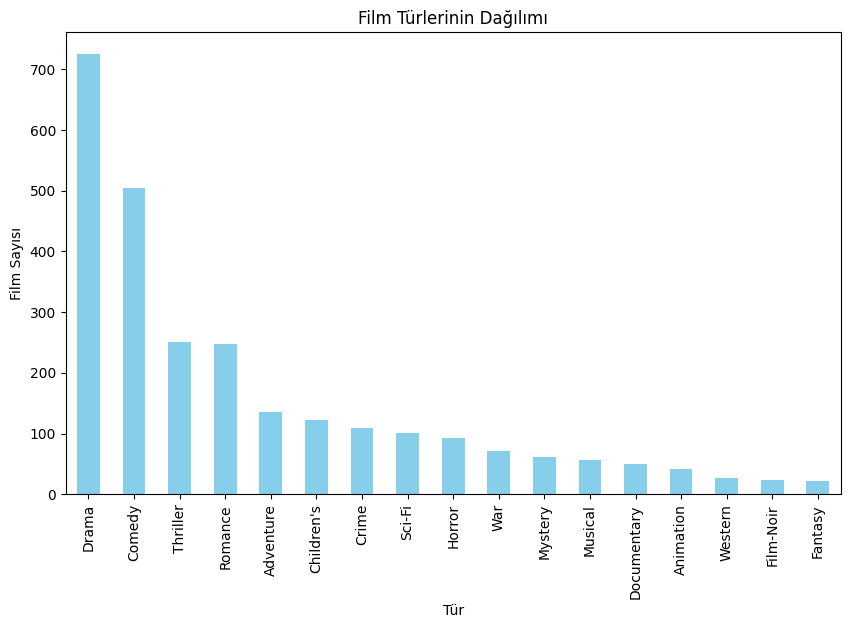

In [23]:
import matplotlib.pyplot as plt

# Türleri say
genre_counts = movies_clean['genres_combined'].str.get_dummies(sep='|').sum().sort_values(ascending=False)

# Görselleştir
plt.figure(figsize=(10,6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title("Film Türlerinin Dağılımı")
plt.xlabel("Tür")
plt.ylabel("Film Sayısı")
plt.show()


In [24]:
# Kullanıcının önerilen filmlerden beğendiği/ beğenmediği simülasyonu
feedback = {title: random.choice([0,1]) for title in recommended_movies}
print("Kullanıcı geri bildirimi (1=beğendi,0=beğenmedi):\n", feedback)


Kullanıcı geri bildirimi (1=beğendi,0=beğenmedi):
 {'Sleeper (1973)': 0, 'Delicatessen (1991)': 0, 'Back to the Future (1985)': 0, 'Coneheads (1993)': 1, 'Junior (1994)': 1}


/tmp/ipython-input-2110535014.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Genre', y='Count', data=genre_counts, palette="viridis")


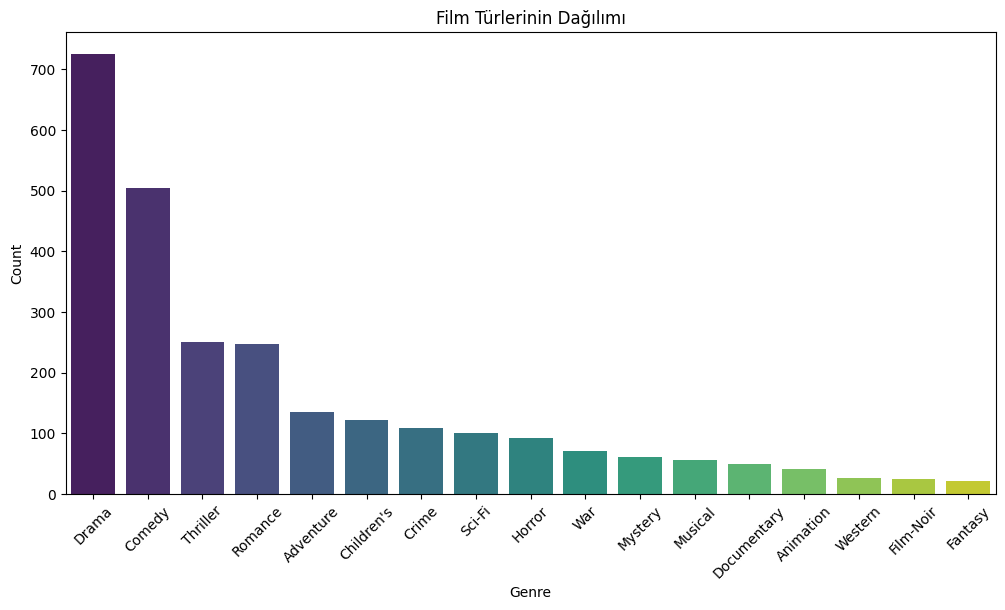

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Türleri say
genre_counts = movies_clean['genres_combined'].str.get_dummies(sep='|').sum().sort_values(ascending=False)
genre_counts = genre_counts.reset_index().rename(columns={'index':'Genre', 0:'Count'})

# Seaborn ile barplot
plt.figure(figsize=(12,6))
sns.barplot(x='Genre', y='Count', data=genre_counts, palette="viridis")
plt.xticks(rotation=45)
plt.title("Film Türlerinin Dağılımı")
plt.show()


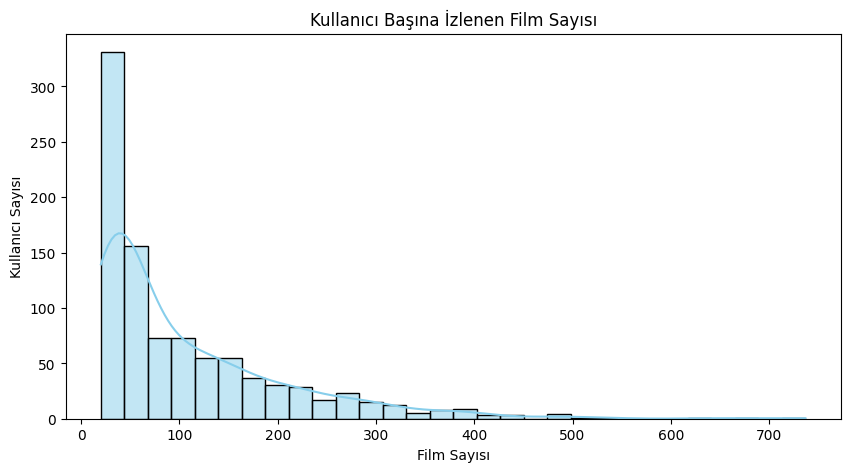

In [26]:
user_movie_count = ratings_clean.groupby('userId')['movieId'].count().reset_index()
user_movie_count.rename(columns={'movieId':'Movie_Count'}, inplace=True)

plt.figure(figsize=(10,5))
sns.histplot(user_movie_count['Movie_Count'], bins=30, kde=True, color='skyblue')
plt.title("Kullanıcı Başına İzlenen Film Sayısı")
plt.xlabel("Film Sayısı")
plt.ylabel("Kullanıcı Sayısı")
plt.show()


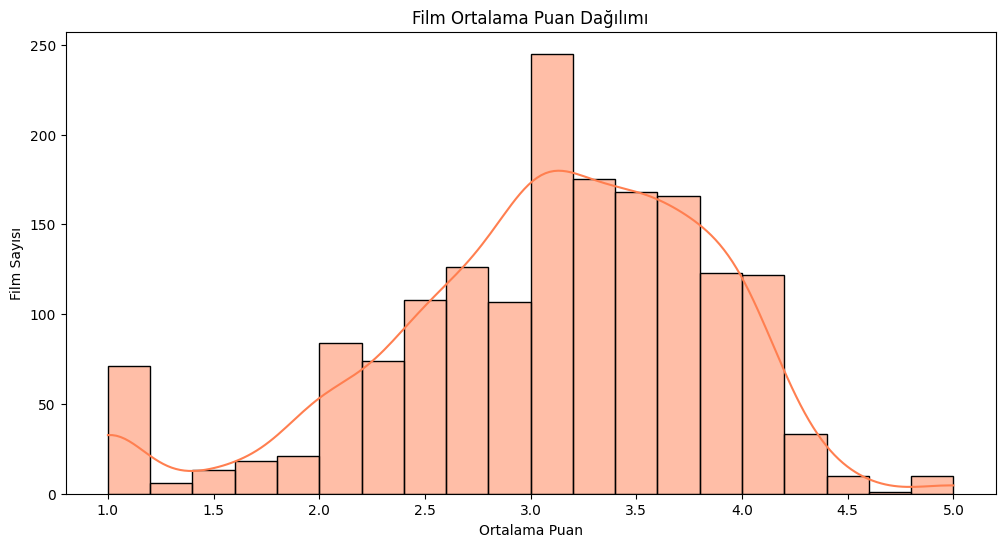

In [27]:
movie_avg_rating = ratings_clean.groupby('movieId')['rating'].mean().reset_index()
movie_avg_rating = movie_avg_rating.merge(movies_clean[['movieId','title']], on='movieId')

plt.figure(figsize=(12,6))
sns.histplot(movie_avg_rating['rating'], bins=20, kde=True, color='coral')
plt.title("Film Ortalama Puan Dağılımı")
plt.xlabel("Ortalama Puan")
plt.ylabel("Film Sayısı")
plt.show()


/tmp/ipython-input-4128221338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recommended_movies.values, y=recommended_movies.index, palette="magma")


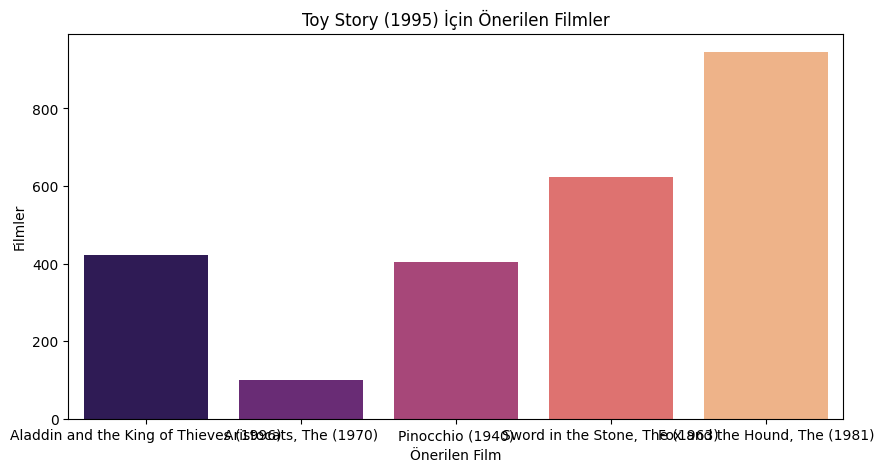

In [28]:
recommended_movies = get_recommendations("Toy Story (1995)")
plt.figure(figsize=(10,5))
sns.barplot(x=recommended_movies.values, y=recommended_movies.index, palette="magma")
plt.title("Toy Story (1995) İçin Önerilen Filmler")
plt.xlabel("Önerilen Film")
plt.ylabel("Filmler")
plt.show()


/tmp/ipython-input-3867750909.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Movie', y='Liked', data=feedback_df, palette="coolwarm")


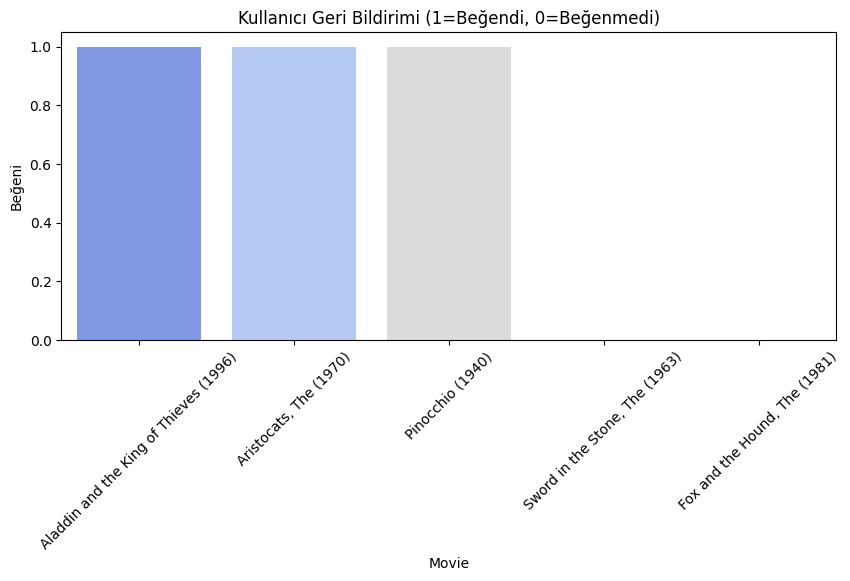

In [29]:
import random
feedback = {title: random.choice([0,1]) for title in recommended_movies}

feedback_df = pd.DataFrame(list(feedback.items()), columns=['Movie','Liked'])
plt.figure(figsize=(10,4))
sns.barplot(x='Movie', y='Liked', data=feedback_df, palette="coolwarm")
plt.title("Kullanıcı Geri Bildirimi (1=Beğendi, 0=Beğenmedi)")
plt.ylabel("Beğeni")
plt.xticks(rotation=45)
plt.show()


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Öneri fonksiyonu (önceki TF-IDF ile)
def get_recommendations(title, cosine_sim=cosine_sim, movies_df=movies_clean, top_n=5):
    if title not in indices:
        print(f"'{title}' filmi bulunamadı!")
        return []
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # kendisi hariç top_n
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices].tolist()

# Konsoldan film adı al
movie_input = input("Film adı girin: ")

# Önerileri al
recommended_movies = get_recommendations(movie_input)

if recommended_movies:
    print(f"\n{movie_input} için önerilen filmler:")
    for i, m in enumerate(recommended_movies,1):
        print(f"{i}. {m}")

    # Görselleştirme
    plt.figure(figsize=(8,5))
    sns.barplot(x=recommended_movies, y=[1]*len(recommended_movies), palette="viridis")
    plt.title(f"{movie_input} için Önerilen Filmler")
    plt.ylabel("Öneri Skoru (sabit)")
    plt.xticks(rotation=45)
    plt.show()

Film adı girin: Toy Story
'Toy Story' filmi bulunamadı!


In [31]:
!pip install ipywidgets fuzzywuzzy python-Levenshtein
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from fuzzywuzzy import process
import ipywidgets as widgets
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.2 MB/s eta 0:00:00


In [32]:

all_movies = movies_clean['title'].tolist()

def get_recommendations_with_scores(title, top_n=5, sim_matrix=cosine_sim):
    if title not in indices:
        return [], []
    idx = indices[title]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]
    titles = movies_clean['title'].iloc[movie_indices].tolist()
    return titles, scores

def autocomplete_movie(user_input, movie_list=all_movies, top_n=5):
    matches = process.extract(user_input, movie_list, limit=top_n)
    return [m[0] for m in matches]

text_input = widgets.Text(
    value='',
    placeholder='Film adını yazın...',
    description='Ara:',
    layout=widgets.Layout(width='60%')
)

suggestions = widgets.Dropdown(
    options=[],
    description='Seçin:',
    layout=widgets.Layout(width='60%')
)

like_button = widgets.ToggleButtons(
    options=[('Beğenmedim', 0), ('Beğendim', 1)],
    description='Geri Bildirim:',
    disabled=False
)

output = widgets.Output()

def on_text_change(change):
    user_input = change['new']
    if user_input:
        suggestions.options = autocomplete_movie(user_input)
    else:
        suggestions.options = []

def on_selection_change(change):
    if change['new']:
        selected_movie = change['new']
        recommended, scores = get_recommendations_with_scores(selected_movie)

        with output:
            clear_output(wait=True)
            print(f"{selected_movie} için önerilen filmler:")
            for i, m in enumerate(recommended,1):
                print(f"{i}. {m} (Benzerlik: {scores[i-1]:.2f})")

            if recommended:
                plt.figure(figsize=(8,5))
                sns.barplot(x=recommended, y=scores, palette="viridis")
                plt.title(f"{selected_movie} için Önerilen Filmler (Benzerlik Skoru)")
                plt.ylabel("Benzerlik Skoru")
                plt.xticks(rotation=45)
                plt.ylim(0,1)
                plt.show()

        # Beğeni butonunu sıfırla
        like_button.value = None

def on_feedback_change(change):
    if change['new'] is not None and suggestions.value:
        feedback = change['new']  # 0=Beğenmedi, 1=Beğendi
        selected_movie = suggestions.value

        # Basit güncelleme: beğenilen film için öneri skorlarını +10% artır
        if feedback == 1:
            idx = indices[selected_movie]
            cosine_sim[idx] = np.clip(cosine_sim[idx] * 1.1, 0, 1)
        else:
            # Beğenilmeyen film için öneri skorlarını %10 düşür
            idx = indices[selected_movie]
            cosine_sim[idx] = np.clip(cosine_sim[idx] * 0.9, 0, 1)

        # Yeniden öneri göster
        on_selection_change({'new': selected_movie})

text_input.observe(on_text_change, names='value')
suggestions.observe(on_selection_change, names='value')
like_button.observe(on_feedback_change, names='value')

display(text_input, suggestions, like_button, output)

Text(value='', description='Ara:', layout=Layout(width='60%'), placeholder='Film adını yazın...')

Dropdown(description='Seçin:', layout=Layout(width='60%'), options=(), value=None)

ToggleButtons(description='Geri Bildirim:', options=(('Beğenmedim', 0), ('Beğendim', 1)), value=0)

Output()

In [33]:
liked_movies = []
disliked_movies = []


genre_columns = movies_clean.columns[2:]
genre_dropdown = widgets.Dropdown(
    options=['All'] + list(genre_columns),
    description='Tür:',
    layout=widgets.Layout(width='50%')
)

search_input = widgets.Text(
    value='',
    placeholder='Film adını yazın...',
    description='Ara:',
    layout=widgets.Layout(width='60%')
)

search_dropdown = widgets.Dropdown(
    options=[],
    description='Seçin:',
    layout=widgets.Layout(width='60%')
)

# ----------------------------
# Butonlar
like_button = widgets.Button(description='Beğendim', button_style='success')
dislike_button = widgets.Button(description='Beğenmedim', button_style='danger')

output = widgets.Output()

# ----------------------------
# Fonksiyonlar
def autocomplete_movie(user_input, movie_list=movies_clean['title'].tolist(), top_n=5):
    matches = process.extract(user_input, movie_list, limit=top_n)
    return [m[0] for m in matches]

def update_dropdown(change):
    user_input = change['new']
    if user_input:
        search_dropdown.options = autocomplete_movie(user_input)
    else:
        search_dropdown.options = []

def get_similar_movies(selected_list, top_n=5, genre_filter=None):
    all_recommended = []
    all_scores = []

    for movie in selected_list:
        idx = indices[movie]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+5]  # biraz fazla al, tür filtresi için

        for i, score in sim_scores:
            rec_movie = movies_clean['title'].iloc[i]
            if rec_movie in liked_movies + disliked_movies:
                continue  # zaten havuzda olanları önleme
            if genre_filter is None or genre_filter=='All' or movies_clean.iloc[i][genre_filter]==1:
                all_recommended.append(rec_movie)
                all_scores.append(score)

    rec_df = pd.DataFrame({'title': all_recommended, 'score': all_scores})
    rec_df = rec_df.groupby('title').mean().reset_index()
    rec_df = rec_df.sort_values('score', ascending=False).head(top_n)
    return rec_df

def add_liked(b):
    movie = search_dropdown.value
    if movie and movie not in liked_movies:
        liked_movies.append(movie)
    update_output()

def add_disliked(b):
    movie = search_dropdown.value
    if movie and movie not in disliked_movies:
        disliked_movies.append(movie)
    update_output()

def update_output():
    genre = genre_dropdown.value
    with output:
        clear_output(wait=True)
        print("Beğendiğiniz filmlere benzer öneriler:")
        if liked_movies:
            rec_df = get_similar_movies(liked_movies, top_n=5, genre_filter=genre)
            for i, row in enumerate(rec_df.itertuples(),1):
                print(f"{i}. {row.title} (Benzerlik: {row.score:.2f})")
            plt.figure(figsize=(8,4))
            sns.barplot(x='title', y='score', data=rec_df, palette='Greens')
            plt.xticks(rotation=45, ha='right')  # sağa hizalı
            plt.ylim(0,1)
            plt.title("Beğenilen Filmlere Benzer")
            plt.tight_layout()
            plt.show()
        else:
            print("Henüz film eklenmedi.")

        print("\nBeğenmediğiniz filmlere benzer öneriler:")
        if disliked_movies:
            rec_df = get_similar_movies(disliked_movies, top_n=5, genre_filter=genre)
            for i, row in enumerate(rec_df.itertuples(),1):
                print(f"{i}. {row.title} (Benzerlik: {row.score:.2f})")
            plt.figure(figsize=(8,4))
            sns.barplot(x='title', y='score', data=rec_df, palette='Reds')
            plt.xticks(rotation=45, ha='right')  # sağa hizalı
            plt.ylim(0,1)
            plt.title("Beğenilmeyen Filmlere Benzer")
            plt.tight_layout()
            plt.show()
        else:
            print("Henüz film eklenmedi.")
# ----------------------------
# Event bağlantıları
search_input.observe(update_dropdown, names='value')
like_button.on_click(add_liked)
dislike_button.on_click(add_disliked)

# ----------------------------
# Display
display(genre_dropdown, search_input, search_dropdown, like_button, dislike_button, output)

Dropdown(description='Tür:', layout=Layout(width='50%'), options=('All', 'genres_combined'), value='All')

Text(value='', description='Ara:', layout=Layout(width='60%'), placeholder='Film adını yazın...')

Dropdown(description='Seçin:', layout=Layout(width='60%'), options=(), value=None)

Button(button_style='success', description='Beğendim', style=ButtonStyle())

Button(button_style='danger', description='Beğenmedim', style=ButtonStyle())

Output()

Bir film türü girin (örn. Action, Comedy, Drama): Drama

📽️ Drama türündeki en iyi filmler:
                                                 title    year    rating
642                               Aiqing wansui (1994)  1996.0  5.000000
674                      Someone Else's America (1995)  1996.0  5.000000
465                                 Prefontaine (1997)  1997.0  5.000000
614               Saint of Fort Washington, The (1993)  1993.0  5.000000
432                     They Made Me a Criminal (1939)  1939.0  5.000000
705  Entertaining Angels: The Dorothy Day Story (1996)  1996.0  5.000000
605                             Pather Panchali (1955)  1996.0  4.625000
575                                        Anna (1996)  1996.0  4.500000
697                           Some Mother's Son (1996)  1996.0  4.500000
135                            Schindler's List (1993)  1993.0  4.466443


/tmp/ipython-input-1180256223.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_movies, x="rating", y="title", palette="viridis")


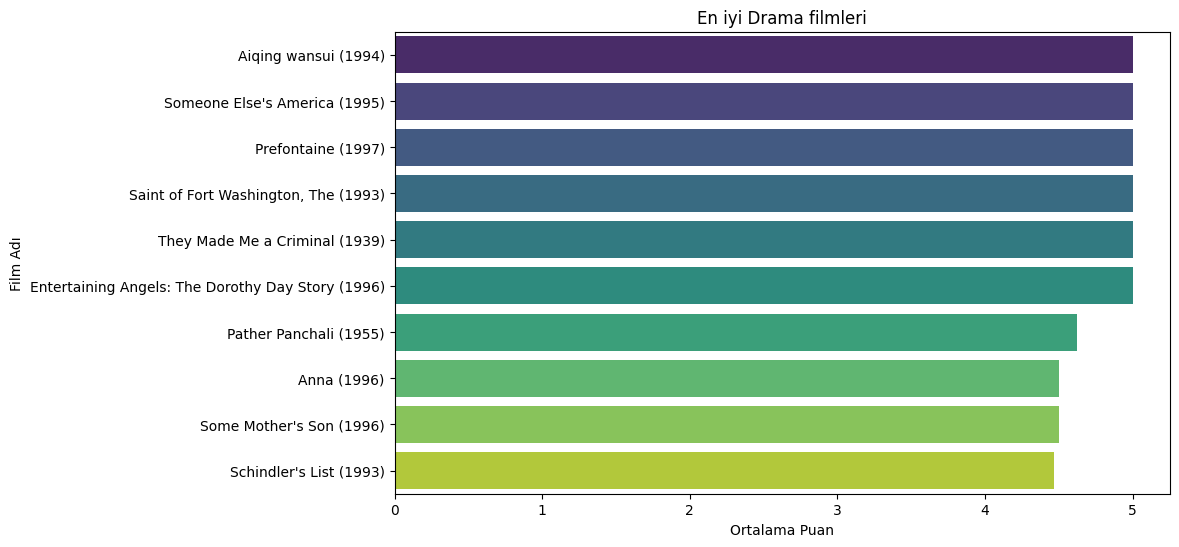

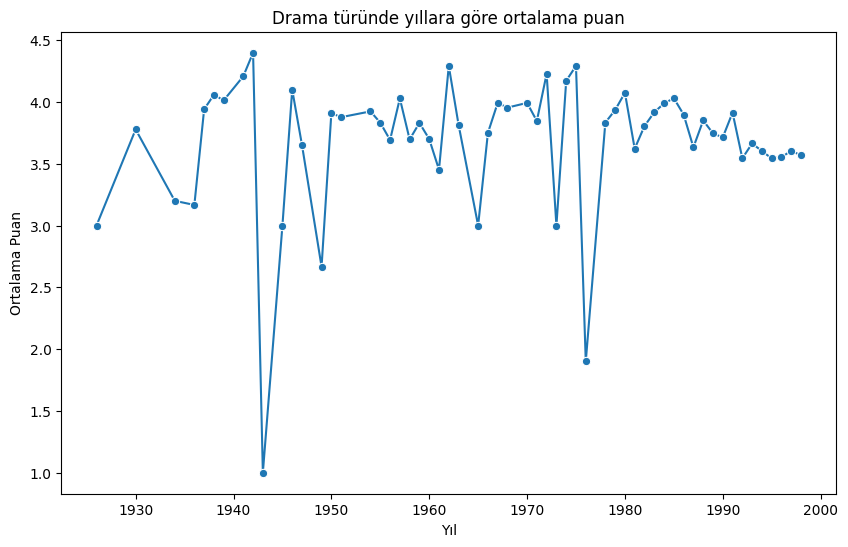

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Dataset path from previous cells
data_path = "/root/.cache/kagglehub/datasets/prajitdatta/movielens-100k-dataset/versions/1/ml-100k"

# Dataset yükleme - u.item dosyasını kullanıyoruz
movies_df = pd.read_csv(
    os.path.join(data_path, "u.item"),
    sep="|",
    encoding="latin-1",
    names=["movieId", "title", "release_date", "video_release_date", "IMDb_URL",
           "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
           "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
           "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
)

# Yıl bilgisini 'release_date' sütunundan alalım ve movies_df'ye ekleyelim
movies_df['year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year
movies_df = movies_df.dropna(subset=['year']) # Eksik yıl bilgisi olanları çıkar

# Ratings datasetini de yükleyelim
ratings_df = pd.read_csv(
    os.path.join(data_path, "u.data"),
    sep="\t",
    names=["userId", "movieId", "rating", "timestamp"]
)

# Filmler ve ratingleri birleştir (sadece gerekli sütunları alarak)
movie_ratings = ratings_df.merge(movies_df[['movieId', 'title', 'year', 'Action', 'Adventure', 'Animation',
                                         "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                                         'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                                         'Thriller', 'War', 'Western']], on='movieId')

# Kullanıcıdan tür alalım
user_genre = input("Bir film türü girin (örn. Action, Comedy, Drama): ")

# Filtreleme - sadece girilen türdeki filmleri seç
# Tür sütunlarını kullanarak filtreleme yapacağız
valid_genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
if user_genre in valid_genres:
    genre_movies = movie_ratings[movie_ratings[user_genre] == 1]
else:
    print(f"Geçersiz tür: {user_genre}. Lütfen şu türlerden birini girin: {', '.join(valid_genres)}")
    genre_movies = pd.DataFrame() # Boş dataframe oluştur

if not genre_movies.empty:

    top_movies = genre_movies.groupby(['movieId', 'title', 'year'])['rating'].mean().reset_index()
    top_movies = top_movies.sort_values(by="rating", ascending=False).head(10)

    print(f"\n📽️ {user_genre} türündeki en iyi filmler:")
    print(top_movies[['title', 'year', 'rating']])

    # Görselleştirme 1: En iyi filmler
    plt.figure(figsize=(10,6))
    sns.barplot(data=top_movies, x="rating", y="title", palette="viridis")
    plt.title(f"En iyi {user_genre} filmleri")
    plt.xlabel("Ortalama Puan")
    plt.ylabel("Film Adı")
    plt.show()

    # Görselleştirme 2: Yıllara göre ortalama puan
    yearly_trend = genre_movies.groupby("year")["rating"].mean().reset_index()

    plt.figure(figsize=(10,6))
    sns.lineplot(data=yearly_trend, x="year", y="rating", marker="o")
    plt.title(f"{user_genre} türünde yıllara göre ortalama puan")
    plt.xlabel("Yıl")
    plt.ylabel("Ortalama Puan")
    plt.show()
else:
    print("Seçilen türde film bulunamadı veya geçersiz tür girildi.")

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
import os

# Dataset path from previous cells
data_path = "/root/.cache/kagglehub/datasets/prajitdatta/movielens-100k-dataset/versions/1/ml-100k"

# Combine movies and ratings for analysis, keeping genre columns
movie_ratings_df = ratings_df.merge(movies_df[['movieId', 'title', 'year', 'Action', 'Adventure', 'Animation',
                                         "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                                         'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                                         'Thriller', 'War', 'Western']], on='movieId')


# All genre columns
genre_columns = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Dropdown with genre options
genre_dropdown_options = ['All'] + genre_columns

# Function to show genre statistics and visualizations
def show_genre_stats(selected_genre):
    if selected_genre == 'All':
        genre_movies = movie_ratings_df.copy()
        title_text = "Tüm Türler"
    else:
        # Filter by selected genre
        genre_movies = movie_ratings_df[movie_ratings_df[selected_genre] == 1].copy()
        title_text = f"{selected_genre} Türü"

    if not genre_movies.empty:
        # En iyi 10 film (ortalama rating'e göre)
        top_movies = genre_movies.groupby(['movieId', 'title', 'year'])['rating'].mean().reset_index()
        # Ensure at least a minimum number of ratings, for example 50
        min_ratings = 50
        rating_counts = genre_movies.groupby(['movieId'])['rating'].count().reset_index()
        valid_movies = rating_counts[rating_counts['rating'] >= min_ratings]['movieId']
        top_movies = top_movies[top_movies['movieId'].isin(valid_movies)]
        top_movies = top_movies.sort_values(by="rating", ascending=False).head(10)


        print(f"\n📽️ {title_text} içindeki en iyi filmler ({min_ratings}+ oy almış):")
        display(top_movies[['title','year','rating']])

        # Barplot
        plt.figure(figsize=(10,6))
        sns.barplot(data=top_movies, x="rating", y="title", palette="viridis")
        plt.title(f"En iyi {title_text} filmleri ({min_ratings}+ oy almış)")
        plt.xlabel("Ortalama Puan")
        plt.ylabel("Film Adı")
        plt.show()

        # Trend grafiği
        yearly_trend = genre_movies.groupby("year")["rating"].mean().reset_index()

        plt.figure(figsize=(10,6))
        sns.lineplot(data=yearly_trend, x="year", y="rating", marker="o")
        plt.title(f"{title_text} türünde yıllara göre ortalama puan")
        plt.xlabel("Yıl")
        plt.ylabel("Ortalama Puan")
        plt.show()
    else:
        print(f"Seçilen türde film bulunamadı veya yeterli sayıda oy almış film yok.")

# Show the dropdown and interact
interact(show_genre_stats, selected_genre=Dropdown(options=genre_dropdown_options, description="Tür:"));

interactive(children=(Dropdown(description='Tür:', options=('All', 'Action', 'Adventure', 'Animation', "Childr…